# Environment Setup:
This notebook is intended to be run on Google Colab. You may complete the tasks offline, but at your own risk.

## Add dataset shortcut from your Google Account
Because of the size of the datasets, we are providing the files from Google Drive.

To access the provided data, go to [this link](https://drive.google.com/drive/folders/1_5LoxbmWDKPKi91Z_HmQn4TFoTtXnxQM?usp=sharing) and click "COMP4211_dataset->Organise->Add shortcut" to save a shortcut in your Google Drive "My Drive" folder (or any specific path in your google drive)

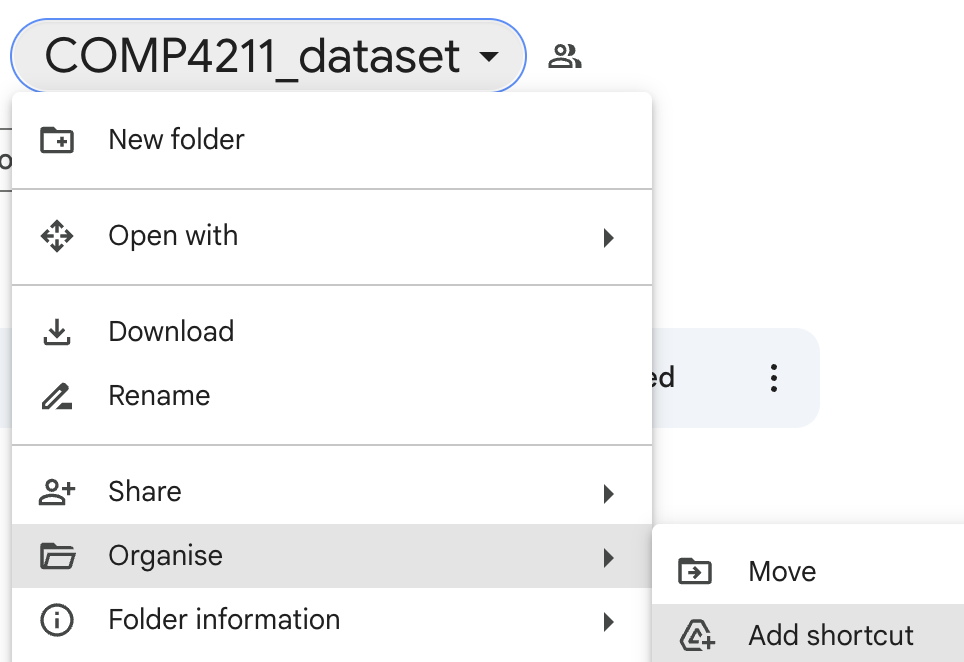

Mount the dataset by the following code (requires authorization):

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/COMP4211_dataset"
vgg_path = os.path.join(data_path, 'vgg19.npz')

pacs_zip = os.path.join(data_path, 'classify/pacs-dataset.zip')
wikiart_zip = os.path.join(data_path, 'wikiart.zip')
coco_zip = os.path.join(data_path, 'COCO.zip')

pacs_path = "classify"
wikiart_path = "wikiart"
coco_path = "COCO"


To speed up the image loading, we unzip the training image datasets to the Google Colab VM rather than access it directly from Google Drive.

In [ ]:
!unzip "$wikiart_zip" > /dev/null 2>&1
!unzip "$coco_zip" > /dev/null 2>&1

(Tip: If you're only doing the second task, skip the above code to save a bit of time)

In [ ]:
# Put the PACS files in a subfolder
!mkdir -p "$pacs_path"
!unzip "$pacs_zip" -d "$pacs_path" > /dev/null 2>&1

## Preparation

This section contains imports and functions that will be used in the later tasks. Some of them are provided.

### Imports

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Important submodules and functions from Tensorflow (and Keras)
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, Reshape, MaxPooling2D, Lambda, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import array_to_img

# Image handling and visualization
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from IPython.display import display
from tqdm.notebook import tqdm
import cv2

# Other utility
import datetime
import psutil

# Module settings:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This will hide all TensorFlow messages, except for errors.
tf.get_logger().setLevel('ERROR')  # This sets TensorFlow logger to only output error messages.

### Utility Functions

**Preprocessing and Deprocessing Images**: In style transfer, images often need to be adjusted before and after passing through the model. The `preprocess` function converts images from RGB (used in most image formats) to BGR (used by the model) and normalizes pixel values by subtracting a mean value. This step helps in aligning the image data with the format expected by the VGG network, which our style transfer model is based on. Conversely, the `deprocess` function reverses these adjustments, converting the image back from BGR to RGB and adding the mean pixel values, making the output image suitable for viewing.

**Loading Images**: The `get_image` function reads an image from the disk, converts it to the RGB format, and optionally resizes it. This function is crucial for preparing your dataset for training or evaluation. It ensures that all images fed into the model are consistent in size and format.

**Finding Images**: The `find_images` function takes a directory path and a file type, and finds (recursively) all files within the directory that matches the file type. This is used for obtaining the images in the WikiArt and COCO dataset, as the images are put in different folders.

In [ ]:
# Prepares an image for the model by converting RGB to BGR and subtracting the mean pixel values.
def preprocess(x):
    img = tf.reverse(x, axis=[-1])  # RGB to BGR
    img -= np.array([103.939, 116.779, 123.68])  # Subtract mean pixel value
    return img

# Converts the output of the model back to a viewable image by adding mean pixel values and converting BGR to RGB.
def deprocess(x):
    img = x + np.array([103.939, 116.779, 123.68])  # Add mean pixel value
    img = tf.reverse(img, axis=[-1])  # BGR to RGB
    img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure pixel value range is valid
    return img

# Loads an image from disk, optionally resizes it, and prepares it for the model.
def get_image(img_path, resize=True, shape=(256,256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    if resize:
        image = cv2.resize(image, shape)  # Resize image
    image = image.astype(np.float32)  # Convert to float32 for model compatibility
    return image

# Finds and returns a list of images (files) within a directory path that matches a certain file type.
def find_images(dir_path, file_type):
    image_paths = []

    for root, _, files in os.walk(dir_path):
        for file in files:
            if f'.{file_type}' in file:
                image_paths.append(os.path.join(root, file))

    return image_paths


### Datasets

This programming assignment requires 2 types of dataset, both used for loading images on-demand:

- `ImageDataset`, a dataset class that finds and collects image files within a given directory, and loads them for training. A single sample should only include the image bitmap (preprocessed using the above functions).
- `ClassificationDataset`, a dataset class that references a given `.tsv` file for file names and labels, and loads the images from the given directory along with the class label. A single sample should include the processed image bitmap, along with its class label in one-hot encoding.

In [ ]:
# [C1]
class ImageDataset:
    def __init__(self, dir_path, batch_size=8, file_type="jpg", random_state = 4211):
        # [Your code here]

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.file_type = file_type
        self.random_state = random_state

        self.ds_pointer = 0

        self.image_path = find_images(dir_path, file_type)

    def reset_pointer(self, seed=None):
        # [Your code here]

        np.random.seed(seed = seed)

        self.ds_pointer = 0

        np.random.shuffle(self.image_path)

    def get_batch(self):
        # [Your code here]

        image_batch = []

        if (self.ds_pointer + self.batch_size - 1) >= self.__len__():
            self.reset_pointer(self.random_state)

        for i in range(self.batch_size):
            image = get_image(self.image_path[self.ds_pointer])
            preprocessed_image = preprocess(image)

            image_batch.append(preprocessed_image)
            self.ds_pointer += 1

        image_batch_arr = np.array(image_batch)

        self.reset_pointer(self.random_state)

        return image_batch_arr


    def __len__(self):
        # [Your code here]

        return len(self.image_path)

# [Q1]
Implement `ImageDataset` according to the above description, and report the result of `__len__` when loading the COCO and WikiArt dataset respectively.

In [ ]:
# [Q1]

wikiart_image_dataset = ImageDataset(wikiart_path)
print("The result of __len__ when loading the WikiArt dataset is: ", len(wikiart_image_dataset))

coco_image_dataset = ImageDataset(coco_path)
print("The result of __len__ when loading the COCO dataset is: ", len(coco_image_dataset))

In [ ]:
# Here's a preview of what the TSV would look like (top 10 rows):
!cat "$pacs_path/train-data.tsv" | head -n 10

In [ ]:
# [C2]
class ClassificationDataset:
    def __init__(self, tsv_path, dir_path, batch_size=8, random_state = 4211):
        # [Your code here]

        self.tsv_path = tsv_path
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.random_state = random_state

        self.ds_pointer = 0

        self.image_path, self.classification_data_table, self.label_class_count = self._process_tsv(tsv_path, dir_path)

    # Tip: It is recommended to use this method to process the tsv data into a data table, since this will be used in both __init__() and add_data().
    def _process_tsv(self, tsv_path, dir_path):
        # pass

        classify_table = pd.read_table(tsv_path, sep = '\t', names = ["filename", "style", "label"])

        no_of_label_classes = classify_table["label"].nunique()

        classify_table_onehot_encoded = pd.get_dummies(classify_table, columns = ["label"], dtype = int)

        image_list = []

        for img_name in classify_table_onehot_encoded["filename"].values:
            image_list.append(os.path.join(dir_path, img_name))

        return image_list, classify_table_onehot_encoded, no_of_label_classes

    def add_data(self, tsv_path, dir_path):
        # [Your code here]

        new_image_path, new_classification_data_table, new_label_class_count = self._process_tsv(tsv_path, dir_path)

        self.image_path = self.image_path + new_image_path

        self.classification_data_table = pd.concat([self.classification_data_table, new_classification_data_table], ignore_index = True)

        self.reset_pointer(self.random_state)

    def reset_pointer(self, seed=None):
        # [Your code here]

        np.random.seed(seed = seed)

        self.ds_pointer = 0

        np.random.shuffle(self.image_path)

        self.classification_data_table = self.classification_data_table.sample(frac = 1, random_state = self.random_state, ignore_index = True)

    def get_batch(self):
        # [Your code here]

        AUGMENT_DIR_PATH = "/content/drive/My Drive/COMP4211_PA2_CLASSIFICATION/derived-files"

        image_batch = []
        onehot_label = []

        if (self.ds_pointer + self.batch_size - 1) >= self.__len__():
            self.reset_pointer(self.random_state)

        for i in range(self.batch_size):

            fname = self.classification_data_table["filename"][self.ds_pointer]

            # Case A: This image is NOT augmented image
            if (fname[:3] == "pic"):
                image = get_image(os.path.join(self.dir_path, self.classification_data_table["filename"][self.ds_pointer]))
            # Case B: This image IS augmented image
            else:
                image = get_image(os.path.join(AUGMENT_DIR_PATH, self.classification_data_table["filename"][self.ds_pointer]))

            preprocessed_image = preprocess(image)

            image_batch.append(preprocessed_image)

            onehot_label_row = self.classification_data_table.iloc[self.ds_pointer, 2:].values.flatten().tolist()
            onehot_label.append(onehot_label_row)

            self.ds_pointer += 1


        image_batch_arr = np.array(image_batch)
        onehot_label_arr = np.array(onehot_label)

        self.reset_pointer(self.random_state)

        return image_batch_arr, onehot_label_arr

    def __len__(self):
        # [Your code here]

        return len(self.classification_data_table.index)

# [Q2]
Implement `ClassificationDataset` according to the above description, and report the result of `__len__` when loading the PACS training and test datasets respectively.

In [ ]:
tsv_path_for_pacs_train = os.path.join(pacs_path, "train-data.tsv")
tsv_path_for_pacs_test = os.path.join(pacs_path, "test-data.tsv")

dir_path_for_pacs_train = os.path.join(pacs_path, "train-files")
dir_path_for_pacs_test = os.path.join(pacs_path, "test-files")


pacs_train_classify_dataset = ClassificationDataset(tsv_path_for_pacs_train, dir_path_for_pacs_train)
print("The result of __len__ when loading the PACS training dataset is: ", len(pacs_train_classify_dataset))

pacs_test_classify_dataset = ClassificationDataset(tsv_path_for_pacs_test, dir_path_for_pacs_test)
print("The result of __len__ when loading the PACS test dataset is: ", len(pacs_test_classify_dataset))

## Part 1: Style Transfer


### Model Components

In [ ]:
class AdaIN(Layer):
    """
    Adaptive Instance Normalization (AdaIN) layer with controllable style transfer intensity.
    This layer adjusts the mean and variance of the content features to match those of the style features,
    then blends the result with the original content features based on a specified alpha value.
    """
    def __init__(self, epsilon=1e-5, **kwargs):
        super(AdaIN, self).__init__(**kwargs)
        self.epsilon = epsilon  # Small constant to avoid division by zero.

    def call(self, inputs):
        content, style, alpha = inputs

        # Compute mean and variance for content and style features.
        meanC, varC = tf.nn.moments(content, [1, 2], keepdims=True)
        meanS, varS = tf.nn.moments(style, [1, 2], keepdims=True)

        # Standard deviation is the square root of variance, adjusted with epsilon for numerical stability.
        sigmaC = tf.sqrt(varC + self.epsilon)
        sigmaS = tf.sqrt(varS + self.epsilon)

        # Perform AdaIN by normalizing content features and scaling them by style's standard deviation and mean.
        normalized_content = (content - meanC) / sigmaC
        stylized_content = normalized_content * sigmaS + meanS

        # Blend stylized content with original content based on alpha.
        blended_content = alpha * stylized_content + (1 - alpha) * content
        return blended_content

In [ ]:
def build_vgg19_enc(input_shape, weights_path):
    weights = np.load(weights_path)

    # [C3] Create vgg19 structure
    # [Your code here]

    model = Sequential(name = "Partial_VGG19")

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu", input_shape = input_shape, name = "conv1_1"))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv1_2"))

    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = "pool1"))

    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv2_1"))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv2_2"))

    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = "pool2"))

    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv3_1"))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv3_2"))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv3_3"))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv3_4"))

    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = "pool3"))

    model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv4_1"))

    # [C4] Load in weights and freeze the model
    # [Your code here]

    counter = 0

    for layer in model.layers:
        if layer.name[0:4] == "conv":

            kernel = weights["arr_%d" % counter]
            counter += 1

            bias = weights["arr_%d" % counter]
            counter += 1

            kernel = kernel.transpose([2, 3, 1, 0])

            kernel = kernel.astype(np.float32)
            bias = bias.astype(np.float32)

            layer.set_weights([kernel, bias])

    model.trainable = False

    return model

def build_vgg19_relus(vgg19):
    relus = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1']
    features = [vgg19.get_layer(relu).output for relu in relus]
    vgg19_relus = Model(inputs=vgg19.input, outputs=features)
    vgg19_relus.trainable = False
    return vgg19_relus

# [C5]
def build_decoder(input_shape):
    # [Your code here]

    model = Sequential(name = "Decoder")

    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu", input_shape = input_shape))

    model.add(UpSampling2D(size = (2, 2)))

    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu"))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu"))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu"))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu"))

    model.add(UpSampling2D(size = (2, 2)))

    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu"))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu"))

    model.add(UpSampling2D(size = (2, 2)))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu"))
    model.add(Conv2D(filters = 3, kernel_size = (3, 3), padding = "same", activation = None))

    # model.summary(expand_nested = True, show_trainable = True)

    return model


def build_model(encoder, decoder, input_shape):
    content = Input(shape=input_shape, name='content')
    style = Input(shape=input_shape, name = 'style')
    alpha = Input(shape=(1,), name='alpha')

    enc_content = encoder(content)
    enc_style = encoder(style)

    adain = AdaIN()([enc_content, enc_style, alpha])

    out = decoder(adain)

    return Model(inputs=[content, style, alpha], outputs=[out, adain])


# [Q4]
Implement the decoder according to Table 2. Report the number of trainable parameters in the decoder.

In [ ]:
model_Q4 = build_decoder((32, 32, 512))

In [ ]:
model_Q4.summary(expand_nested = True, show_trainable = True)

In [ ]:
def get_loss(encoder, vgg19_relus, epsilon=1e-5, style_weight=1.0):

    def loss(y_true, y_pred):
        out, adain = y_pred[0], y_pred[1]

        # Encode output and compute content_loss
        out = deprocess(out)
        out = preprocess(out)
        enc_out = encoder(out)
        content_loss = tf.reduce_sum(tf.reduce_mean(tf.square(enc_out - adain), axis=[1, 2]))

        # Compute style loss from vgg relus
        style = y_true[1]
        style_featues = vgg19_relus(style)
        gen_features = vgg19_relus(out)
        style_layer_loss = []
        for enc_style_feat, enc_gen_feat in zip(style_featues, gen_features):
            meanS, varS = tf.nn.moments(enc_style_feat, [1, 2])
            meanG, varG = tf.nn.moments(enc_gen_feat,   [1, 2])

            sigmaS = tf.sqrt(varS + epsilon)
            sigmaG = tf.sqrt(varG + epsilon)

            l2_mean  = tf.reduce_sum(tf.square(meanG - meanS))
            l2_sigma = tf.reduce_sum(tf.square(sigmaG - sigmaS))

            style_layer_loss.append(l2_mean + l2_sigma)

        style_loss = tf.reduce_sum(style_layer_loss)

        # Compute the total loss
        weighted_style_loss = style_weight * style_loss
        total_loss = content_loss + weighted_style_loss
        return total_loss, content_loss, weighted_style_loss

    return loss

### Training Routine

In [ ]:
# [C6]
def part1_train(model, content_ds, style_ds, loss_fn, n_epochs = 2, save_interval = 1, save_path=None, load_path=None):
    # Initialize the Optimizer
    # [Your code here]
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, weight_decay = 5e-5)

    # Calculate the number of batches per epoch
    # [Your code here]
    ###np.ceil(len(style_ds) / style_ds.batch_size, dtype = np.int64)
    n_batches = max((len(content_ds) // content_ds.batch_size), (len(style_ds) // style_ds.batch_size))

    # Initialize other things
    process = psutil.Process(os.getpid())
    alpha = 1.0

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        # [Your code here]

        content_ds.reset_pointer(content_ds.random_state)
        style_ds.reset_pointer(style_ds.random_state)

        # Define Loss Metrics. To be updated in each batch
        losses = {"total": 0.0, "content": 0.0, "style": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            # [Your code here]

            # Load a batch of samples from the datasets (content and style here)
            content_batch = content_ds.get_batch()
            style_batch = style_ds.get_batch()

            # Execute Batch Training
            # Tip: Use tf.GradientTape() when computing the loss, to obtain the gradient.
            # [Your code here]

            # Pass the content and style images (along with an alpha value) wrapped in a single array to obtain the model output.
            input_arr_for_VGG19_model = [content_batch, style_batch, alpha]


            ###output, adain = model(input_arr_for_VGG19_model)


            # Pass the model output along with the content and style image to the loss function to compute the loss.
            ###y_true = [content_batch, style_batch]
            ###y_pred = [output, adain]


            ###total_loss, content_loss, weighted_style_loss = loss_fn(y_true, y_pred)


            # Obtain the gradients of the total loss with respect to the model’s trainable variables, using tf.GradientTape().
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_weights)
                output, adain = model(input_arr_for_VGG19_model)

                # Pass the model output along with the content and style image to the loss function to compute the loss.
                y_true = [content_batch, style_batch]
                y_pred = [output, adain]

                total_loss, content_loss, weighted_style_loss = loss_fn(y_true, y_pred)

            # Apply the gradients using the optimizer initialized before the loop.
            # This is where the model learns by updating its weights based on the computed gradients.
            grad = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grad, model.trainable_weights))

            # Update Loss Metrics
            # [Your code here]
            losses["total"] = (losses["total"] * i + total_loss) / (i + 1)
            losses["content"] = (losses["content"] * i + content_loss) / (i + 1)
            losses["style"] = (losses["style"] * i + weighted_style_loss) / (i + 1)

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform a save on the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)

### Model setup

In [ ]:
def part1_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 16 # Recommended according to the Google Colab T4 GPU

    content_ds = ImageDataset(coco_path, batch_size=BATCH_SIZE)
    style_ds = ImageDataset(wikiart_path, batch_size=BATCH_SIZE)

    return content_ds, style_ds

def part1_setup():
    #####
    # MODIFY SETTINGS HERE
    #####
    STYLE_WEIGHT = 2.0
    EPSILON = 1e-5

    INPUT_SHAPE = (None, None, 3) # We accept any image size

    # Build model
    vgg19 = build_vgg19_enc(INPUT_SHAPE, vgg_path)  # encoder
    decoder = build_decoder(vgg19.output.shape[1:])  # input shape == encoder output shape
    model = build_model(vgg19, decoder, INPUT_SHAPE)

    # Get loss
    vgg19_relus = build_vgg19_relus(vgg19)
    loss = get_loss(vgg19, vgg19_relus, epsilon=EPSILON, style_weight=STYLE_WEIGHT)

    return model, loss

In [ ]:
content_ds, style_ds = part1_prepare_datasets()

In [ ]:
model, loss = part1_setup()

We can now start the training:

In [ ]:
#####
# We recommend you to save on your mounted Google Drive folder,
# otherwise it may get lost after the Colab session terminated
#####
PART1_SAVE_PATH = "/content/drive/My Drive/saved.h5" # Change to your own path.

# part1_train(model, content_ds, style_ds, loss, n_epochs=3, save_path=PART1_SAVE_PATH)

In [ ]:
part1_train(model, content_ds, style_ds, loss, n_epochs=3, save_path=PART1_SAVE_PATH)

In [ ]:
###model.save(PART1_SAVE_PATH)

In [ ]:
# To continue to train the saved weights, do this:
PART1_LOAD_PATH = '/content/drive/My Drive/saved.h5' # Change to your own path

# part1_train(model, content_ds, style_ds, loss, n_epochs=3, save_path=PART1_SAVE_PATH, load_path=PART1_LOAD_PATH)

In [ ]:
part1_train(model, content_ds, style_ds, loss, n_epochs=3, save_path=PART1_SAVE_PATH, load_path=PART1_LOAD_PATH)

Note: Due to the limited computing time available in Colab, it may be a good idea to divide the training into different sessions, by saving and loading the model weights in your Google Drive.  

Do not save the weights outside the drive or they will be deleted after the session ends!

### Inference

In [ ]:
# [C7]
def part1_inference(model_path, content_path, style_path, alpha):
    model = load_model(model_path, custom_objects={'AdaIN': AdaIN})

    # Get content image
    # [Your code here]
    raw_content_image = get_image(content_path, resize = False)
    raw_content_image_expand_dimension = np.expand_dims(raw_content_image, axis = 0)
    content_image_preprocessed = preprocess(raw_content_image_expand_dimension)

    # Get style image
    # [Your code here]
    raw_style_image = get_image(style_path, resize = False)
    raw_style_image_expand_dimension = np.expand_dims(raw_style_image, axis = 0)
    style_image_preprocessed = preprocess(raw_style_image_expand_dimension)

    # Set alpha Value
    # [Your code here]
    alpha_tf = tf.constant(alpha)
    alpha_tf_1D = tf.reshape(alpha_tf, [1])

    # Do inference
    # [Your code here]
    output_image, adain = model.predict([content_image_preprocessed, style_image_preprocessed, alpha_tf_1D])

    # Convert output array to image
    # [Your code here]
    # img = array_to_img(y)

    output_image_2D = np.squeeze(output_image, axis = 0)
    output_image_deprocessed = deprocess(output_image_2D)
    img = array_to_img(output_image_deprocessed)

    # Display the image in the Notebook
    # display(img)

    display(img)

In [ ]:
"""
#####
# MODIFY SETTINGS HERE
#####
ALPHA = 0.75
MODEL_PATH = PART1_SAVE_PATH
# Here below is a sample, please change to your own path
CONTENT_PATH = os.path.join(data_path, 'HKUST/dyyeung.jpg')
# Here below is a sample, please change to your own path
STYLE_PATH = os.path.join(data_path, 'wikiart/Analytical_Cubism/juan-gris_portrait-of-maurice-raynal-1911.jpg')

part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)
"""

In [ ]:
"""
# Another sample, please change and test on your own
ALPHA=0.75
CONTENT_PATH = os.path.join(data_path, 'HKUST/7.jpeg')
MODEL_PATH = PART1_SAVE_PATH
STYLE_PATH = os.path.join(data_path, 'Extra_styles/the-starry-night.jpg')
part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)
"""

In [ ]:
#####
# MODIFY SETTINGS HERE
#####
ALPHA = 0.75
MODEL_PATH = PART1_SAVE_PATH
# Here below is a sample, please change to your own path
CONTENT_PATH = os.path.join(data_path, 'HKUST/dyyeung.jpg')
# Here below is a sample, please change to your own path
STYLE_PATH = os.path.join('wikiart/Analytical_Cubism/juan-gris_portrait-of-maurice-raynal-1911.jpg')

part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

In [ ]:
# Another sample, please change and test on your own
ALPHA = 0.75
CONTENT_PATH = os.path.join(data_path, 'HKUST/7.jpeg')
MODEL_PATH = PART1_SAVE_PATH
STYLE_PATH = os.path.join(data_path, 'Extra_styles/the-starry-night.jpg')
part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

In [ ]:
# This is the cover page of my report

ALPHA = 0.85
CONTENT_PATH = os.path.join("/content/drive/MyDrive/COMP4211_dataset/HKUST/15.jpeg")
MODEL_PATH = PART1_SAVE_PATH
STYLE_PATH = os.path.join("/content/wikiart/Pop_Art/andy-warhol_goethe.jpg")

part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, ALPHA)

# [Q8]
Demonstrate the model’s ability to combine the content and style of images effectively, showcasing several examples in your report.

In [ ]:
def show_example_images(model_path, content_path, style_path):
    ALPHA = [0.2, 0.5, 0.65, 0.9]
    MODEL_PATH = model_path

    CONTENT_PATH = content_path
    STYLE_PATH = style_path

    f, axarr = plt.subplots(1, 2)

    content_img = mpimg.imread(content_path)
    axarr[0].imshow(content_img)
    axarr[0].set_title("Content Image")

    style_img = mpimg.imread(style_path)
    axarr[1].imshow(style_img)
    axarr[1].set_title("Style Image")

    plt.show()

    for a in ALPHA:
        print("\n")
        print("When alpha = ", a, ":")
        part1_inference(MODEL_PATH, CONTENT_PATH, STYLE_PATH, a)

In [ ]:
# Example 1

model_path_1 = PART1_SAVE_PATH
content_path_1 = "/content/drive/MyDrive/COMP4211_dataset/HKUST/dyyeung.jpg"
style_path_1 = "/content/wikiart/Fauvism/charles-lapicque_l-orage-en-mer-1946.jpg"

show_example_images(model_path_1, content_path_1, style_path_1)

In [ ]:
# Example 2

model_path_2 = PART1_SAVE_PATH
content_path_2 = "/content/drive/MyDrive/COMP4211_dataset/HKUST/3.jpg"
style_path_2 = "/content/wikiart/Minimalism/eva-hesse_right-after-1969.jpg"

show_example_images(model_path_2, content_path_2, style_path_2)

In [ ]:
# Example 3

model_path_3 = PART1_SAVE_PATH
content_path_3 = "/content/drive/MyDrive/COMP4211_dataset/HKUST/5.jpg"
style_path_3 = "/content/wikiart/Post_Impressionism/charles-cottet_four-breton-women-at-the-seashore-1893.jpg"

show_example_images(model_path_3, content_path_3, style_path_3)

## Part 2: Classification Task

The second part of this assignment is a Classification Task, but with an unideal training dataset.

This task uses the PACS dataset (an image dataset with images of different categories and in different styles), but modified to have an abnormal distribution between styles and categories.

### Analyzing the dataset

Before we start the classification task, let's load and obtain some basic info about our training dataset.

In [ ]:
def part2_prepare_datasets():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    TEST_DS_PATH = os.path.join(pacs_path, "test-files/")
    TEST_TSV_PATH = os.path.join(pacs_path, "test-data.tsv")

    train_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    test_ds = ClassificationDataset(TEST_TSV_PATH, TEST_DS_PATH, batch_size = BATCH_SIZE)

    return train_ds, test_ds

train_ds, test_ds = part2_prepare_datasets()

Find out the distribution of images in diferent styles and categories:

In [ ]:
# [C8]
def part2_tally_samples(dataset):
    # [Your code here]
    df = dataset.classification_data_table.iloc[:, 1:]

    df_style = df.iloc[:, 0]

    style_name = pd.unique(df_style)

    print("Tallies of each pair of (style, label):")
    for style in style_name:
        df_result = df[df["style"] == style]

        print("\n")
        print("When the style is ", style, ", the corresponding tally of each label is:")
        print(df_result.sum(axis = 0, numeric_only = True))

part2_tally_samples(train_ds)

Compare this to the test dataset:

In [ ]:
part2_tally_samples(test_ds)

### Main Implementation

The architecture of the classification model is also a VGG19 model, adapted for multiclass classification.

In [ ]:
# [C9]
def build_vgg19_classifier(input_shape, num_class):
    # Create vgg19 structure
    # [Your code here]

    model = Sequential(name = "VGG19_Classifier")

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu", input_shape = input_shape, name = "conv1_1"))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv1_2"))

    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = "pool1"))

    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv2_1"))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv2_2"))

    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = "pool2"))

    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv3_1"))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv3_2"))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv3_3"))
    model.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv3_4"))

    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), name = "pool3"))

    model.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu", name = "conv4_1"))

    model.add(GlobalAveragePooling2D(name = "global_pool"))

    model.add(Dense(units = 1024, activation = "relu", name = "dense1"))
    model.add(Dense(units = 1024, activation = "relu", name = "dense2"))
    model.add(Dense(units = 512, activation = "relu", name = "dense3"))
    model.add(Dense(units = num_class, activation = "softmax", name = "dense4"))

    # model.summary(expand_nested = True, show_trainable = True)

    return model

In [ ]:
# [This part is not graded but is required for successful completion of other tasks]
def part2_setup(LOAD_PATH = None):
    INPUT_SHAPE = (None, None, 3)

    # Build model
    # model = ... # [Your code here]
    model = build_vgg19_classifier(INPUT_SHAPE, 7)

    # Get Loss
    # loss_fn = ... # [Your code here]
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    if LOAD_PATH:
        model.load_weights(LOAD_PATH)

    return model, loss_fn

model2, loss2 = part2_setup()

# [Q11]
Implement a function to construct the classifier model. Report the number of trainable parameters in the model.

In [ ]:
model2.summary(expand_nested = True, show_trainable = True)

### Training the model with the given dataset

In [ ]:
# [C10]
def part2_train(model, dataset, loss_fn, n_epochs = 100, save_interval = 1, save_path=None, load_path=None):
    # Initialize the Optimizer
    # optimizer = ... # [Your code here]
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, weight_decay = 5e-5)

    # Calculate the number of batches per epoch
    # n_batches = ... # [Your code here]
    n_batches = len(dataset) // dataset.batch_size

    # Initialize other things
    process = psutil.Process(os.getpid())

    # Load weights if provided
    if load_path:
        model.load_weights(load_path)

    # Run for n epochs
    for e in range(1, n_epochs+1):
        pbar = tqdm(total=n_batches)
        # Reset Dataset Iterators
        # [Your code here]
        dataset.reset_pointer(dataset.random_state)

        # Define Loss Metrics. To be updated in each batch
        losses = {"cross-entropy": 0.0}

        # Run for all batches
        for i in range(n_batches):
            # Fetch Training Batches
            # [Your code here]

            # Load a batch of samples from the datasets
            image_batch, onehot_label_batch = dataset.get_batch()


            # Execute Batch Training
            # [Your code here]


            # Pass the content and style images (along with an alpha value) wrapped in a single array to obtain the model output.

            # Pass the model output along with the content and style image to the loss function to compute the loss.

            # Obtain the gradients of the total loss with respect to the model’s trainable variables, using tf.GradientTape().
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_weights)
                output = model(image_batch)

                # Pass the model output (predicted labels) along with true labels from the batch to compute the categorial cross entropy loss
                y_true = onehot_label_batch
                y_pred = output

                cross_etp_loss = loss_fn(y_true, y_pred)


            # Apply the gradients using the optimizer initialized before the loop.
            # This is where the model learns by updating its weights based on the computed gradients.
            grad = tape.gradient(cross_etp_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grad, model.trainable_weights))

            # Update Loss Metrics
            # [Your code here]
            losses["cross-entropy"] = (losses["cross-entropy"] * i + cross_etp_loss) / (i + 1)

            # Visualize loss during training
            string = "".join([f"{key} loss: {value:.3f}\t" for key, value in losses.items()])
            pbar.set_description(f"Epoch {e}/{n_epochs}\t" + string)
            pbar.update(1)

        # In case the session ends before the training is done, perform save the model from time to time:
        if e % save_interval == 0:
            if save_path:
                model.save(save_path)


In [ ]:
# Train the model
PART2_SAVE_PATH = "/content/drive/My Drive/classify.h5" # [Change to your own path]

# [Call your train function here]
# part2_train(model2, train_ds, loss2, n_epochs = 100, save_interval = 1, save_path = PART2_SAVE_PATH, load_path = None)

In [ ]:
part2_train(model2, train_ds, loss2, n_epochs = 100, save_interval = 1, save_path = PART2_SAVE_PATH, load_path = None)

In [ ]:
# To continue to train the saved weights, do this
PART2_LOAD_PATH = "/content/drive/My Drive/classify.h5"

# part2_train(model2, train_ds, loss2, n_epochs = 10, save_interval = 1, save_path = PART2_SAVE_PATH, load_path = PART2_LOAD_PATH)

In [ ]:
part2_train(model2, train_ds, loss2, n_epochs = 1, save_interval = 1, save_path = PART2_SAVE_PATH, load_path = PART2_LOAD_PATH)

### Testing

We can now test our first classifier model with the test dataset (maybe train dataset too, to make sure the training went properly).

Calculate the accuracy of the model, as well as the confusion matrix to for a clearer idea on the model's performance:

In [ ]:
# [C11]
def part2_evaluate(model, dataset):
    # [Your code here]

    # call the required accuracy function
    CatAcc = tf.keras.metrics.CategoricalAccuracy()


    # store the initial batch size to initial_batch_size
    initial_batch_size = dataset.batch_size

    # change the dataset.batch_size to the lenth of the whole dataset
    length_of_whole_dataset = len(dataset)
    dataset.batch_size = length_of_whole_dataset

    # get all the images and corresponding one-hot label of the datasdet
    all_image_batch, all_true_onehot_labels = dataset.get_batch()

    # change dataset.batch_size back to initial_batch_size
    dataset.batch_size = initial_batch_size

    # use model to do prediction
    all_pred_onehot_labels = model.predict(all_image_batch)


    # reset the state of categorical accuracy
    CatAcc.reset_state()

    # put all the true labels and prediction labels inside CatAcc
    CatAcc.update_state(all_true_onehot_labels, all_pred_onehot_labels)

    # get the accuracy
    accuracy = CatAcc.result()
    accuracy = float(accuracy)

    # output the accuracy
    print("The accuracy of the model across all batches is: ", accuracy)

    print("\n")

    # reset the state of categorical accuracy
    CatAcc.reset_state()

    # use argmax on all_true_onehot_labels & all_pred_onehot_labels
    # to get true_label & prediction_label
    true_label = tf.math.argmax(all_true_onehot_labels, axis = 1)
    prediction_label = tf.math.argmax(all_pred_onehot_labels, axis = 1)

    #  create the confusion matrix
    conf_matrix = tf.math.confusion_matrix(labels = true_label,
                                           predictions = prediction_label,
                                           num_classes = dataset.label_class_count)

    conf_matrix = np.array(conf_matrix)

    # show the confusion matrix
    print("The confusion matrix is:")
    print(conf_matrix)

    print("\n")

    # visualize the confusion matrix

    label_list = list(dataset.classification_data_table.columns[2:])
    label_list_organized = []
    for label in label_list:
        label_list_organized.append(label[6:])

    fig = plt.figure()
    ax = fig.add_subplot(111)

    conf_ax = ax.matshow(conf_matrix, interpolation ='nearest')
    fig.colorbar(conf_ax)

    ax.set_xticklabels([""] + label_list_organized)
    ax.set_yticklabels([""] + label_list_organized)


    print("The visualized confusion matrix is:")

    # plt.matshow(conf_matrix)
    plt.show()

# [Q13]
Report the accuracy and confusion matrix of the model trained in the previous section, when tested against the training and test datasets respectively.

In [ ]:
model_Q13_train = load_model(PART2_LOAD_PATH)
model_Q13_test = load_model(PART2_LOAD_PATH)

In [ ]:
print("For training dataset: ")
print("\n")
part2_evaluate(model_Q13_train, train_ds)

In [ ]:
print("For testing dataset: ")
print("\n")
part2_evaluate(model_Q13_test, test_ds)

# [Q14]
Showcase some of the mislabeled sample images (with their true and reported samples). Discuss your observations (and possible explanation) on some of these failure cases.

In [ ]:
# Prepare the model for prediction
model_Q14 = load_model(PART2_LOAD_PATH)

# Reset the pointer for the test dataset
test_ds.reset_pointer(test_ds.random_state)

# Get a batch of image & corresponding one-hot labels
image_batch, true_onehot_label = test_ds.get_batch()

# Do prediction on the obtained batch of image
prediction_onehot_label = model_Q14.predict(image_batch)

# Convert one-hot back to the normal one
true_label = tf.math.argmax(true_onehot_label, axis = 1)
prediction_label = tf.math.argmax(prediction_onehot_label, axis = 1)

# Convert back to NumPy array
true_label = np.array(true_label)
prediction_label = np.array(prediction_label)

# Let see which sample images are mislabeled
print("True labels:")
print(true_label)
print("\n")
print("Predicted labels:")
print(prediction_label)

In [ ]:
# Create a NumPy array to obtain which indices of image does not match
boolean_mislabel = (true_label != prediction_label)
# print(boolean_mislabel)

mislabel_labeled_indices = np.where(boolean_mislabel == True)[0]
print("The mislabel images' indice(s) is/are:")
print(mislabel_labeled_indices)

In [ ]:
# Declare how many mislabeled images to show
minimum_number_mislabel_to_show = min(6, len(mislabel_labeled_indices))

# Prepare a list that contains the 7 labels
label_list = list(test_ds.classification_data_table.columns[2:])
label_list_organized = []
for label in label_list:
    label_list_organized.append(label[6:])


# Use a for loop to get some mislabeled images (with their true label & predicted label)
for i in mislabel_labeled_indices[:minimum_number_mislabel_to_show]:

    print("True label: ", label_list_organized[true_label[i]])
    print("Predicted label: ", label_list_organized[prediction_label[i]])

    image_arr = image_batch[i]
    img = array_to_img(image_arr)
    display(img)

    print("\n\n")

### Data Augmentation with Style Transfer

In [ ]:
# [C12]
def part2_transfer(model, dataset, content_idx, style_idx, alpha):
    # [Your code here]
    # Tip: A large part of part1_inference can be applied here.

    data_table = dataset.classification_data_table

    # Extract a random image A with label l
    filename_A = data_table.iloc[content_idx, 0]
    path_A = os.path.join("/content/classify/train-files", filename_A)

    # Extract a random image B with style s
    filename_B = data_table.iloc[style_idx, 0]
    path_B = os.path.join("/content/classify/train-files", filename_B)

    # Create a new image C with A as content image and B as style image

    # Get image A
    image_A = get_image(path_A, resize = False)
    image_A_expand_dimension = np.expand_dims(image_A, axis = 0)
    image_A_preprocessed = preprocess(image_A_expand_dimension)

    # Get image B
    image_B = get_image(path_B, resize = False)
    image_B_expand_dimension = np.expand_dims(image_B, axis = 0)
    image_B_preprocessed = preprocess(image_B_expand_dimension)

    # Set alpha Value
    alpha_tf = tf.constant(alpha)
    alpha_tf_1D = tf.reshape(alpha_tf, [1])

    # Create a new image C
    new_image_C, adain = model.predict([image_A_preprocessed, image_B_preprocessed, alpha_tf_1D])

    # Convert output array to image
    new_image_C_2D = np.squeeze(new_image_C, axis = 0)
    new_image_C_deprocessed = deprocess(new_image_C_2D)
    img = array_to_img(new_image_C_deprocessed)

    ##display(img)

    # Instead of displaying the image, return it to be saved:
    return img

In [ ]:
# [C12]
def part2_augment(part1_load_path, dataset, output_tsv, output_dir, samples_per_pair = 50, alpha = 0.75, random_state = 4211):
    # We don't want to reload the model for every single sample,
    # so we load one here and pass it to the transfer function:
    # model = ... # [Your code here]
    model = load_model(part1_load_path, custom_objects = {'AdaIN': AdaIN})

    # Get label and style samples to transfer from
    # These are expected to be in the form of
    # { "(label/style name)": [(list of indices in the dataset that corresponds to the label/style)], ... }
    # Tip: If you can have a pandas Dataframe from the dataset, you can use groupby(...).indices here.
    # labeldict = ... # [Your code here]
    # styledict = ... # [Your code here]

    data_table = dataset.classification_data_table


    onehot_label = data_table.iloc[:,2:]
    initial_label_col = pd.from_dummies(onehot_label)
    initial_label_col.columns = ["label"]
    label_dict_arr = initial_label_col.groupby(initial_label_col.columns[0]).indices

    labeldict = {k[6:]: v.tolist() for k, v in label_dict_arr.items()}

    ##print("labeldict: ", labeldict)


    style_dict_array = data_table.groupby(data_table.columns[1]).indices
    styledict = {key: value.tolist() for key, value in style_dict_array.items()}

    ##print("styledict: ", styledict)


    # Generate random samples
    rng = np.random.default_rng(random_state)
    derived_tsv = "" # For usage in ClassificationDataset
    pair_set = set() # To prevent generating duplicates
    for label, label_idxs in labeldict.items():
        for style, style_idxs in styledict.items():
            for _ in range(samples_per_pair):
                pair = None
                while not pair or pair in pair_set:
                    pair = rng.choice(label_idxs), rng.choice(style_idxs)
                pair_set.add(pair)

                # Generate 1 sample
                img = part2_transfer(model, dataset, pair[0], pair[1], alpha)

                # Make up a name for the same sample. Don't repeat the names!
                # derived_name = ... # [Your code here]

                filename_label = data_table.iloc[pair[0], 0][:-4]
                filename_style = data_table.iloc[pair[1], 0][:-4]

                derived_name = "AUGMENT_" + filename_label + "_MIX_" + filename_style + "_(" + label + "," + style + ")" + ".jpg"

                ##print("derived_name: ", derived_name)

                # Add an entry to the TSV file. Follow the format of "train-data.tsv" and "test-data.tsv"!
                # derived_entry = ... # [Your code here]
                derived_entry = derived_name + "\t" + style + "\t" + label + "\n"

                ##print("derived_entry: ", derived_entry)

                # Save the image in the given folder
                img.save(os.path.join(output_dir, derived_name))
                # Add entry to the TSV to be written
                derived_tsv += derived_entry

    # Write the entries into the given file name
    with open(output_tsv, "w") as f:
        f.write(derived_tsv)


In [ ]:
# PART1_MODEL_PATH = os.path.join(data_path, 'saved.h5') # [Change to your part_1 saved weight]
PART1_MODEL_PATH = "/content/drive/MyDrive/saved.h5"
ALPHA = 0.75

# OUTPUT_TSV = "classify/derived-data.tsv"
# OUTPUT_DIR = "classify/derived-files"

OUTPUT_TSV = "/content/drive/My Drive/COMP4211_PA2_CLASSIFICATION/derived-data.tsv"
OUTPUT_DIR = "/content/drive/My Drive/COMP4211_PA2_CLASSIFICATION/derived-files"


# Before running the augmentation, it is a good idea to prepare an empty directory for the generated outputs:
def part2_cleanup_augments(output_dir):
    !rm -rf "$output_dir"
    !mkdir -p "$output_dir"

In [ ]:
!cat "$OUTPUT_TSV"

In [ ]:
# Generate the dataset:
part2_cleanup_augments(OUTPUT_DIR)
part2_augment(PART1_MODEL_PATH, train_ds, OUTPUT_TSV, OUTPUT_DIR, samples_per_pair = 50, alpha = ALPHA, random_state = 4211)

### Training the model with an augmented dataset

After generating the images we can produce a new, augmented dataset for retraining. We would like to add the data to the existing train dataset, in order to have a more balanced distribution between different styles and categories.

In [ ]:
def part2_prepare_aug_dataset():
    #####
    # MODIFY SETTINGS HERE
    #####
    BATCH_SIZE = 64
    TRAIN_DS_PATH = os.path.join(pacs_path, "train-files/")
    TRAIN_TSV_PATH = os.path.join(pacs_path, "train-data.tsv")
    # DERIVED_DS_PATH = os.path.join(pacs_path, "derived-files/")
    # DERIVED_TSV_PATH = os.path.join(pacs_path, "derived-data.tsv")
    DERIVED_DS_PATH = "/content/drive/My Drive/COMP4211_PA2_CLASSIFICATION/derived-files/"
    DERIVED_TSV_PATH = "/content/drive/My Drive/COMP4211_PA2_CLASSIFICATION/derived-data.tsv"

    train2_ds = ClassificationDataset(TRAIN_TSV_PATH, TRAIN_DS_PATH, batch_size = BATCH_SIZE)
    train2_ds.add_data(DERIVED_TSV_PATH, DERIVED_DS_PATH)

    return train2_ds

train2_ds = part2_prepare_aug_dataset()

We can confirm the augmentation by looking at its distribution:

In [ ]:
part2_tally_samples(train2_ds)

Now we can train another classifier using the augmented data:

In [ ]:
# [This part is not graded but is required for successful completion of other tasks]
def part2_2_setup(LOAD_PATH = None):
    INPUT_SHAPE = (None, None, 3)

    # Build model
    # model = ... # [Your code here]
    model = build_vgg19_classifier(INPUT_SHAPE, 7)

    # Get Loss
    # loss_fn = ... # [Your code here]
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    if LOAD_PATH:
        model.load_weights(LOAD_PATH)

    return model, loss_fn

model2_2, loss2_2 = part2_2_setup()

In [ ]:
PART2_SAVE_PATH_2 = "/content/drive/My Drive/classify-augmentation.h5" # [Change to your own path]

# [Call your train function here, training on train2_ds]
# part2_train(model2_2, train2_ds, loss2_2, n_epochs = 100, save_interval = 1, save_path = PART2_SAVE_PATH_2, load_path = None)

In [ ]:
part2_train(model2_2, train2_ds, loss2_2, n_epochs = 100, save_interval = 1, save_path = PART2_SAVE_PATH_2, load_path = None)

In [ ]:
# To continue to train the saved weights, do this
PART2_LOAD_PATH_2 = "/content/drive/My Drive/classify-augmentation.h5"

# part2_train(model2_2, train2_ds, loss2_2, n_epochs = 40, save_interval = 1, save_path = PART2_SAVE_PATH_2, load_path = PART2_LOAD_PATH_2)

In [ ]:
part2_train(model2_2, train2_ds, loss2_2, n_epochs = 40, save_interval = 1, save_path = PART2_SAVE_PATH_2, load_path = PART2_LOAD_PATH_2)

Test the model for any performance changes. After that, feel free to explore on more ways to improve the model!

# [Q17]
Test the new model against the test (and un-augmented training) dataset, then report and compare the result with one before augmentation.

*Accuracy & Confusion Matrix:*

In [ ]:
model_Q17_test = load_model(PART2_LOAD_PATH_2)
model_Q17_train_unaugmented = load_model(PART2_LOAD_PATH_2)

In [ ]:
print("For the testing dataset: ")
print("\n")
part2_evaluate(model_Q17_test, test_ds)

In [ ]:
print("For the unaugmented training dataset: ")
print("\n")
part2_evaluate(model_Q17_train_unaugmented, train_ds)

*Showcase some of the mislabeled sample images:*

In [ ]:
# Prepare the model for prediction
model_Q17 = load_model(PART2_LOAD_PATH_2)

# Reset the pointer for the test dataset
test_ds.reset_pointer(test_ds.random_state)

# Get a batch of image & corresponding one-hot labels
image_batch, true_onehot_label = test_ds.get_batch()

# Do prediction on the obtained batch of image
prediction_onehot_label = model_Q17.predict(image_batch)

# Convert one-hot back to the normal one
true_label = tf.math.argmax(true_onehot_label, axis = 1)
prediction_label = tf.math.argmax(prediction_onehot_label, axis = 1)

# Convert back to NumPy array
true_label = np.array(true_label)
prediction_label = np.array(prediction_label)

# Let see which sample images are mislabeled
print("True labels:")
print(true_label)
print("\n")
print("Predicted labels:")
print(prediction_label)

In [ ]:
# Create a NumPy array to obtain which indices of image does not match
boolean_mislabel = (true_label != prediction_label)
# print(boolean_mislabel)

mislabel_labeled_indices = np.where(boolean_mislabel == True)[0]
print("The mislabel images' indice(s) is/are:")
print(mislabel_labeled_indices)

In [ ]:
# Declare how many mislabeled images to show
minimum_number_mislabel_to_show = min(6, len(mislabel_labeled_indices))

# Prepare a list that contains the 7 labels
label_list = list(test_ds.classification_data_table.columns[2:])
label_list_organized = []
for label in label_list:
    label_list_organized.append(label[6:])


# Use a for loop to get some mislabeled images (with their true label & predicted label)
for i in mislabel_labeled_indices[:minimum_number_mislabel_to_show]:

    print("True label: ", label_list_organized[true_label[i]])
    print("Predicted label: ", label_list_organized[prediction_label[i]])

    image_arr = image_batch[i]
    img = array_to_img(image_arr)
    display(img)

    print("\n\n")

# [Q18]
Give a possible explanation on the two results (e.g., how the augmentation affected the test-time performance).

In [ ]:
part2_tally_samples(train2_ds)